<a href="https://colab.research.google.com/github/MihirDesh/Segment-Anything-Model/blob/main/SAM_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!pip install -q git+https://github.com/huggingface/transformers

['  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 '  Building wheel for transformers (pyproject.toml) ... \x1b[?25l\x1b[?25hdone']

In [2]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os

In [3]:
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [4]:
np_config.enable_numpy_behavior()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

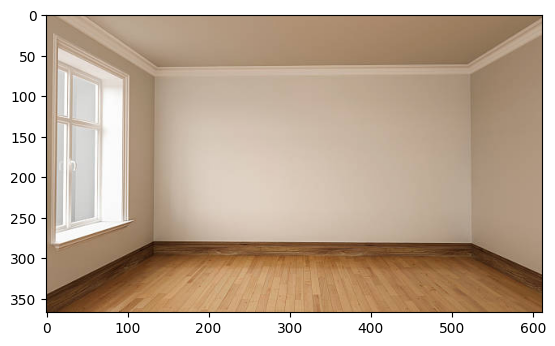

In [13]:
img_url = "https://media.istockphoto.com/id/521806786/photo/3d-rendering-of-empty-room-interior-white-brown-colors.jpg?s=612x612&w=0&k=20&c=njPof128FBEo4KjyC8ONDUPS0aBBkFEial5Uy8xoqdA="
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
plt.imshow(raw_image)
plt.show()

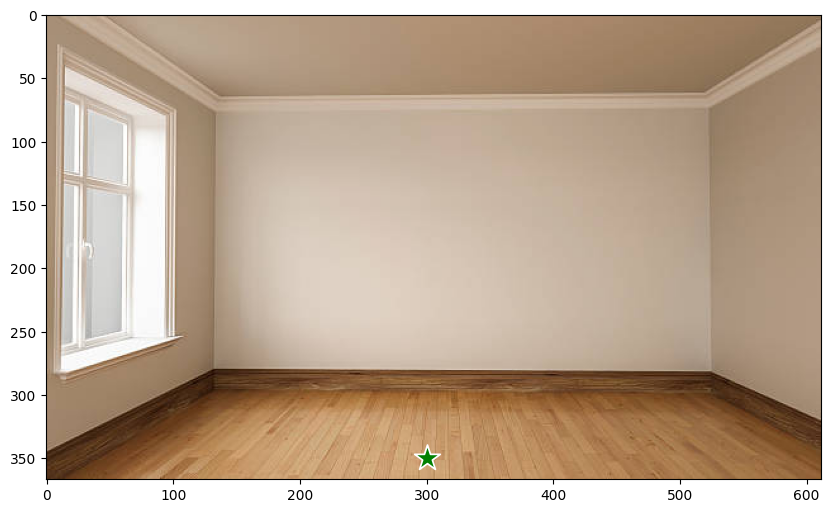

In [14]:
input_points = [[[300, 350]]]

# Visualize a single point.
show_points_on_image(raw_image, input_points[0])

In [15]:
# Preprocess the input image.
inputs = processor(raw_image, input_points=input_points, return_tensors="tf")

# Predict for segmentation with the prompt.
outputs = model(**inputs)

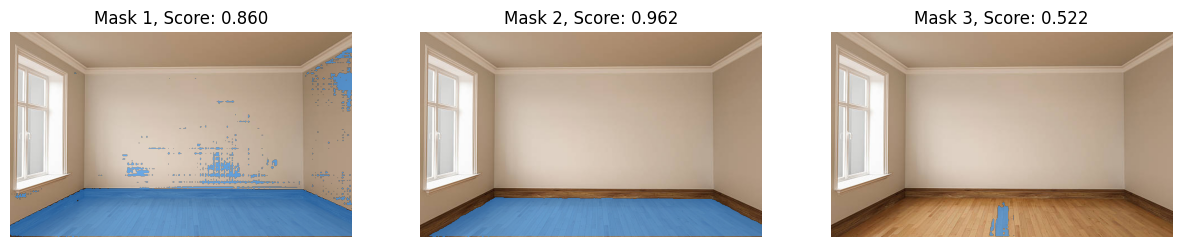

In [16]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf",
)

show_masks_on_image(raw_image, masks, outputs.iou_scores)

In [9]:
remote_path = "https://hf.co/datasets/sayakpaul/sample-datasets/resolve/main/breast-cancer-dataset.tar.gz"
dataset_path = keras.utils.get_file(
    "breast-cancer-dataset.tar.gz", remote_path, untar=True
)

8652800/8652800 [==============================] - 0s 0us/step


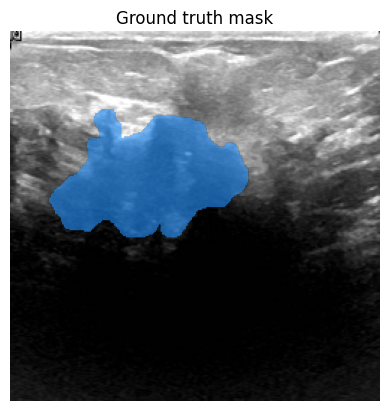

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([256, 256], dtype=int32)>

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# Load all the image and label paths.
image_paths = sorted(glob.glob(os.path.join(dataset_path, "images/*.png")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "labels/*.png")))

# Load the image and label.
idx = 15
image = Image.open(image_paths[idx])
label = Image.open(label_paths[idx])
image = np.array(image)
ground_truth_seg = np.array(label)

# Display.
fig, axes = plt.subplots()
axes.imshow(image)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")
plt.show()

tf.shape(ground_truth_seg)

In [11]:
class Generator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, dataset_path, processor):
        self.dataset_path = dataset_path
        self.image_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "images/*.png"))
        )
        self.label_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "labels/*.png"))
        )
        self.processor = processor

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path))
            ground_truth_mask = np.array(Image.open(label_path))

            # get bounding box prompt
            prompt = self.get_bounding_box(ground_truth_mask)

            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")

            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs

    def get_bounding_box(self, ground_truth_map):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        return bbox

In [12]:
# Define the output signature of the generator class.
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}

# Prepare the dataset object.
train_dataset_gen = Generator(dataset_path, processor)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)

In [13]:
auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 4

train_ds = (
    train_ds.cache()
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

In [14]:
sample = next(iter(train_ds))
for k in sample:
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))

pixel_values (2, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (2, 2) <dtype: 'int64'> True
reshaped_input_sizes (2, 2) <dtype: 'int64'> True
input_boxes (2, 1, 4) <dtype: 'float64'> True
ground_truth_mask (2, 256, 256) <dtype: 'int32'> True


In [15]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        # reducing spatial dimensions and batch
        reduce_axis = [0] + reduce_axis
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o
    # calculate DICE coefficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss

In [16]:
# initialize SAM model and optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
optimizer = keras.optimizers.Adam(1e-5)

for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False


@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True,
        )

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # calculate loss over predicted and ground truth masks
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # update trainable variables
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))

        return loss

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [17]:
# run training
for epoch in range(3):
    for inputs in train_ds:
        loss = train_step(inputs)
    print(f"Epoch {epoch + 1}: Loss = {loss}")

KeyboardInterrupt: 

In [ ]:
# Load another image for inference.
idx = 20
raw_image_inference = Image.open(image_paths[idx])

# process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

In [ ]:
infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]
show_masks_on_image(raw_image_inference, masks=infer_masks, scores=iou_scores)